In [2]:
from collections import defaultdict
from typing import Dict
from pathlib import Path
from IPython.display import display
import pandas as pd
import numpy as np



In [3]:
%config InlineBackend.figure_format='retina'


In [4]:
targets = pd.read_csv(Path('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/targets.csv.gz'), index_col=0)
folds = pd.read_csv(Path('../datasets/experiments/MoS2-plain-cv/folds.csv'), index_col=0)
targets.columns = pd.MultiIndex.from_product([['DFT'], targets.columns])
targets = targets.assign(folds=folds)


In [5]:
exp_dir_name_mapper = {
    'MoS2-plain-cv': 'MEGNet',
    'MoS2-plain-cv-catboost': 'Catboost+Matminer',
    'MoS2-plain-cv-gemnet': 'GemNet',
    'MoS2-plain-cv-schnet': 'SchNet',
}

exp_name_mapper = {
    'megnet-full.csv.gz': 'MEGNet',
    'megnet-sparse.csv.gz': 'MEGNet-Sparse',
    'megnet-sparse-eos.csv.gz': 'MEGNet-Sparse-EOS',
    'catboost-test.csv.gz': 'Catboost+Matminer',
    'schnet-full.csv.gz': 'SchNet',
    'gemnet-full.csv.gz': 'GemNet'
}


target_name_pretty_mapper = {
    'homo': 'HOMO',
    'lumo': 'LUMO',
    'band_gap': 'Bandgap',
    'formation_energy_per_site': 'Formation energy per site',
}

target_short_name_pretty_mapper = {
    'homo': 'HOMO',
    'lumo': 'LUMO',
    'band_gap': 'Bandgap',
    'formation_energy_per_site': 'Formation',
}

In [6]:
predictions = Path('../datasets/predictions').resolve()
predictions = list(predictions.rglob('*.csv.gz'))
# Filter out other directories based on the mapper above
# file.parts[-3] correspond to directory name
predictions = list(filter(
    lambda file: file.parts[-3] in exp_dir_name_mapper.keys(),
    predictions
))


In [7]:
data = defaultdict(dict)
for file in predictions: 
    exp_name = exp_name_mapper.get(file.name)
    # target_name = target_name_mapper.get(file.parts[-2]) 
    target_name = file.parts[-2] 
 
    data[exp_name][target_name] = pd.read_csv(file, index_col=0)

In [8]:
def make_df_from_trial(data: dict, name: str):
    df = pd.concat(data, axis=1)
    df.columns = df.columns.droplevel(-1)
    # Append each attribute with _pred
    # df = df.add_suffix('_pred')
    # Add Higher level index (name of experiment)
    df.columns = pd.MultiIndex.from_product([[name], df.columns])
    # [[name] * len(df.columns), [col + ' predicted' for col in df.columns]]
    return df

In [9]:
predictions = pd.concat([make_df_from_trial(v, k) for k, v in data.items()], axis=1)
# Concat with actual data
predictions = pd.concat([predictions, targets], axis=1)

# reindex with folds
predictions.index = pd.MultiIndex.from_arrays([predictions.index, predictions.folds])
# drop folds column
predictions = predictions.drop('folds', level=0, axis=1)

In [10]:
predictions

Catboost+Matminer                            \
                                        band_gap formation_energy_per_site   
_id                      folds                                               
6141cf0efbfd4bd9ab2c2f7e 2              1.117471                  2.769009   
6141cf0f51c1cbd9654b8870 2              1.057708                  2.659575   
6141cf0fe689ecc4c43cdd4b 3              1.647190                  0.784382   
6141cf10b842c2e72e2f2d44 5              1.804401                  0.184275   
6141cf1051c1cbd9654b8872 4              1.096639                  2.669430   
...                                          ...                       ...   
6148f3f63ac25c70a5c6cdff 5              0.356436                  4.146777   
6149087231cf3ef3d4a9f848 6              0.260021                  3.296777   
6149c48031cf3ef3d4a9f84a 7              0.376480                  3.412673   
6149f3853ac25c70a5c6ce01 7              0.363715                  4.090032   
615083823ac25c70a5c6ce03 1              0.374448                  3.986911   

                                            GemNet                            \
                                    homo  band_gap formation_energy_per_site   
_id                      folds                                                 
6141cf0efbfd4bd9ab2c2f7e 2     -0.638735  0.402019                  2.889449   
6141cf0f51c1cbd9654b8870 2     -0.677077  0.406166                  2.948149   
6141cf0fe689ecc4c43cdd4b 3     -0.678564  0.396737                  1.786147   
6141cf10b842c2e72e2f2d44 5     -0.684090  0.376325                  1.078119   
6141cf1051c1cbd9654b8872 4     -0.670878  0.411880                  3.069151   
...                                  ...       ...                       ...   
6148f3f63ac25c70a5c6cdff 5     -0.541923  0.390380                  4.154788   
6149087231cf3ef3d4a9f848 6     -0.432594  0.280273                  3.313599   
6149c48031cf3ef3d4a9f84a 7     -0.507742  0.352018                  3.377668   
6149f3853ac25c70a5c6ce01 7     -0.573291  0.387973                  3.824775   
615083823ac25c70a5c6ce03 1     -0.578072  0.352164                  3.925790   

                                                      SchNet  \
                                    homo      lumo  band_gap   
_id                      folds                                 
6141cf0efbfd4bd9ab2c2f7e 2     -0.657741 -0.195418  0.392363   
6141cf0f51c1cbd9654b8870 2     -0.659049 -0.193416  0.390486   
6141cf0fe689ecc4c43cdd4b 3     -0.589095 -0.152070  0.388200   
6141cf10b842c2e72e2f2d44 5     -0.530069 -0.064264  0.377756   
6141cf1051c1cbd9654b8872 4     -0.585801 -0.212619  0.391952   
...                                  ...       ...       ...   
6148f3f63ac25c70a5c6cdff 5     -0.579105 -0.193635  0.393508   
6149087231cf3ef3d4a9f848 6     -0.434522 -0.158832  0.378598   
6149c48031cf3ef3d4a9f84a 7     -0.505707 -0.154307  0.390690   
6149f3853ac25c70a5c6ce01 7     -0.557184 -0.179236  0.393481   
615083823ac25c70a5c6ce03 1     -0.561668 -0.190133  0.391483   

                                                                    ...  \
                               formation_energy_per_site      homo  ...   
_id                      folds                                      ...   
6141cf0efbfd4bd9ab2c2f7e 2                      4.076340 -0.557408  ...   
6141cf0f51c1cbd9654b8870 2                      4.096680 -0.555105  ...   
6141cf0fe689ecc4c43cdd4b 3                      3.277271 -0.550087  ...   
6141cf10b842c2e72e2f2d44 5                      2.471660 -0.530699  ...   
6141cf1051c1cbd9654b8872 4                      4.089738 -0.561750  ...   
...                                                  ...       ...  ...   
6148f3f63ac25c70a5c6cdff 5                      4.143724 -0.552466  ...   
6149087231cf3ef3d4a9f848 6                      3.345916 -0.531843  ...   
6149c48031cf3ef3d4a9f84a 7                      3.416878 -0.536584  ...   
6149f3853ac25c70a5c6

# Results

## Calculate LUMO

In [11]:
for group, df in predictions.groupby(level=0, axis=1):
    # we skip those since it already been calculated
    if group in ['DFT', 'GemNet']: 
        continue
    df.columns = df.columns.droplevel(0)
    predictions.loc[:, (group, 'lumo')] = df.homo + df.band_gap

predictions = predictions.sort_index(axis=1)

## Metrics

In [12]:
def to_latex(df, column_names=None, **kwargs):
    if column_names:
        df.columns = column_names
            
    return df.to_latex(
        escape=False,
        multicolumn_format='c',
        column_format='l' + 'c' * len(df.columns),
        float_format="%.3f",
        **kwargs
        )
    

In [13]:
def wrapper(df: pd.DataFrame, col_name: str, ground_truth: pd.DataFrame, metric_fn):
    df.columns = df.columns.droplevel(0)
    x = df[col_name]
    y = ground_truth
    return metric_fn(x, y)

def mae(x, y):
    return np.abs(x - y)

def energy_within_threshold(prediction, target):
    # compute absolute error on energy per system.
    # then count the no. of systems where max energy error is < 0.000002.
    e_thresh = 0.02
    error_energy = np.abs(target - prediction)

    success = np.sum(error_energy < e_thresh)
    total = target.shape[0]
    return success / total

### EwT

In [14]:
EwT = {}
for attr in ['homo', 'lumo', 'formation_energy_per_site', 'band_gap']:
    EwT[attr] = predictions.groupby(level=0, axis=1).apply(
        lambda df: wrapper(df, col_name=attr, ground_truth=predictions['DFT', attr], metric_fn=energy_within_threshold)
        )
EwT = pd.DataFrame(EwT).rename(target_short_name_pretty_mapper, axis=1)
display(EwT)

,HOMO,LUMO,Formation,Bandgap
Catboost+Matminer,0.894488,0.954155,0.946233,0.832968
DFT,1.000000,1.000000,1.000000,1.000000
GemNet,0.653632,0.579808,0.827743,0.445306
MEGNet,0.892466,0.581830,0.337603,0.498736
MEGNet-Sparse,0.950615,0.945727,0.953312,0.917411
MEGNet-Sparse-EOS,0.950952,0.955672,0.961739,0.921793
SchNet,0.627676,0.617563,0.474465,0.503118


### MAE

In [21]:
MAE = {}
sigma = {}
for attr in ['homo', 'lumo', 'formation_energy_per_site', 'band_gap']:
    # calculate the absolute error of each row
    _df = predictions.groupby(level=0, axis=1).apply(
        lambda df: wrapper(df, col_name=attr, ground_truth=predictions['DFT', attr], metric_fn=mae)
        )
    
    MAE[attr] = _df.mean()

    # std of mae of each fold 
    folds_mean = _df.groupby(level=1, axis=0).mean()
    sigma[attr] = pd.DataFrame(
        (folds_mean.sem() / folds_mean.mean()) * 100, # Relative standard error
        columns=[f'{target_short_name_pretty_mapper[attr]}']
        )
    
MAE = pd.DataFrame(MAE).rename(target_short_name_pretty_mapper, axis=1)
display(MAE)


,HOMO,LUMO,Formation,Bandgap
Catboost+Matminer,0.006814,0.005979,0.007678,0.010369
DFT,0.000000,0.000000,0.000000,0.000000
GemNet,0.018737,0.063409,0.023933,0.065087
MEGNet,0.007566,0.048120,0.055232,0.050782
MEGNet-Sparse,0.004868,0.006270,0.007105,0.007194
MEGNet-Sparse-EOS,0.004788,0.006103,0.007607,0.007197
SchNet,0.020676,0.036895,0.075619,0.045382


### MAE Relative Standard Error

In [22]:
error = pd.concat(sigma, axis=1).dropna()
error.columns = error.columns.droplevel(0)
error.columns = pd.MultiIndex.from_product([['Relative Standard Error \% $\downarrow$'], list(error.columns)])
display(error)
error = to_latex(
        error,
        caption='This table shows the relative standard error of Mean absolute difference of each fold',
        label='table:rse'
    )
print(error)

Relative Standard Error \% $\downarrow$             \
                                                     HOMO       LUMO   
Catboost+Matminer                                2.860879   2.461116   
GemNet                                           4.554132  19.307116   
MEGNet                                           6.857572  41.605623   
MEGNet-Sparse                                    2.584305   2.541979   
MEGNet-Sparse-EOS                                3.144346   3.270602   
SchNet                                           1.575680   3.861137   

                                         
                   Formation    Bandgap  
Catboost+Matminer   6.864107   3.399083  
GemNet              8.134868  20.465289  
MEGNet             18.702306  38.703755  
MEGNet-Sparse       6.671076   3.190756  
MEGNet-Sparse-EOS  11.764140   1.937244  
SchNet              3.764465   3.505242

\begin{table}
\centering
\caption{This table shows the relative standard error of Mean absolute difference of each fold}
\label{table:rse}
\begin{tabular}{lcccc}
\toprule
{} & \multicolumn{4}{c}{Relative Standard Error \% $\downarrow$} \\
{} &                                    HOMO &   LUMO & Formation & Bandgap \\
\midrule
Catboost+Matminer &                                   2.861 &  2.461 &     6.864 &   3.399 \\
GemNet            &                                   4.554 & 19.307 &     8.135 &  20.465 \\
MEGNet            &                                   6.858 & 41.606 &    18.702 &  38.704 \\
MEGNet-Sparse     &                                   2.584 &  2.542 &     6.671 &   3.191 \\
MEGNet-Sparse-EOS &                                   3.144 &  3.271 &    11.764 &   1.937 \\
SchNet            &                                   1.576 &  3.861 &     3.764 &   3.505 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3441225/1300134162.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(


### Combined tables

In [23]:
mae_ewt = pd.concat([MAE, EwT], axis=1).drop('DFT')
display(mae_ewt)

mae_ewt = to_latex(
        mae_ewt,
        column_names=[
            [r'MAE (eV) $\downarrow$']*4 +  [r'EwT (\%) $\uparrow$']*4,
            mae_ewt.columns
            ],
        caption='The table shows the mean absoulte difference (MAE) and energy within threshold (EwT) for the calculated energies',
        label='table:mae_ewt'

)

print(mae_ewt)

,HOMO,LUMO,Formation,Bandgap,HOMO,LUMO,Formation,Bandgap
Catboost+Matminer,0.006814,0.005979,0.007678,0.010369,0.894488,0.954155,0.946233,0.832968
GemNet,0.018737,0.063409,0.023933,0.065087,0.653632,0.579808,0.827743,0.445306
MEGNet,0.007566,0.048120,0.055232,0.050782,0.892466,0.581830,0.337603,0.498736
MEGNet-Sparse,0.004868,0.006270,0.007105,0.007194,0.950615,0.945727,0.953312,0.917411
MEGNet-Sparse-EOS,0.004788,0.006103,0.007607,0.007197,0.954155,0.956683,0.961739,0.926176
SchNet,0.020676,0.036895,0.075619,0.045382,0.627676,0.617563,0.474465,0.503118


\begin{table}
\centering
\caption{The table shows the mean absoulte difference (MAE) and energy within threshold (EwT) for the calculated energies}
\label{table:mae_ewt}
\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{MAE (eV) $\downarrow$} & \multicolumn{4}{c}{EwT (\%) $\uparrow$} \\
{} &                  HOMO &  LUMO & Formation & Bandgap &                HOMO &  LUMO & Formation & Bandgap \\
\midrule
Catboost+Matminer &                 0.007 & 0.006 &     0.008 &   0.010 &               0.894 & 0.954 &     0.946 &   0.833 \\
GemNet            &                 0.019 & 0.063 &     0.024 &   0.065 &               0.654 & 0.580 &     0.828 &   0.445 \\
MEGNet            &                 0.008 & 0.048 &     0.055 &   0.051 &               0.892 & 0.582 &     0.338 &   0.499 \\
MEGNet-Sparse     &                 0.005 & 0.006 &     0.007 &   0.007 &               0.951 & 0.946 &     0.953 &   0.917 \\
MEGNet-Sparse-EOS &                 0.005 & 0.006 &     0.008 &   0.007 &

/tmp/ipykernel_3441225/1300134162.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(


### Plots

In [24]:
import matplotlib.pyplot as plt
import getpass
from itertools import groupby


In [25]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

plt.show()
def plot(predictions, true_targets, experiment_name, target_name, plots_folder=Path('./plots')):
    mae = np.abs(predictions - true_targets).mean()
    fig, ax = plt.subplots()
    ax.scatter(true_targets,
                predictions,
                label=f"$\mathrm{{MAE}}={mae:.4f}$",
                alpha=0.5)
    ax.set_xlabel(f"DFT {target_name}, eV")
    ax.set_ylabel(f"Predicted {target_name}, eV")
    ax.legend()

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plots_folder.mkdir(exist_ok=True, parents=True)

    metadata = {
        "Title": f"Predictions for {target_name} "
                    f"for experiment {experiment_name}",
        "Keywords": "2D materials, machine learning, graph neural network, MEGNet"}
    try:
        metadata["Author"] = getpass.getuser()
    except:
        pass
    filename = Path(plots_folder, f"{experiment_name}_{target_name}.png", dpi=192)
    # plt.axis('square')
    ax.margins(x=0, y=0)

    set_size(6, 6, ax=ax)
    fig.savefig(filename,
                # bbox_inches='tight',
                # pad_inches=0?.5,
                metadata=metadata)
    ax.set_title(experiment_name)
    # fig.show()
    return filename

/tmp/ipykernel_3441225/2237389202.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


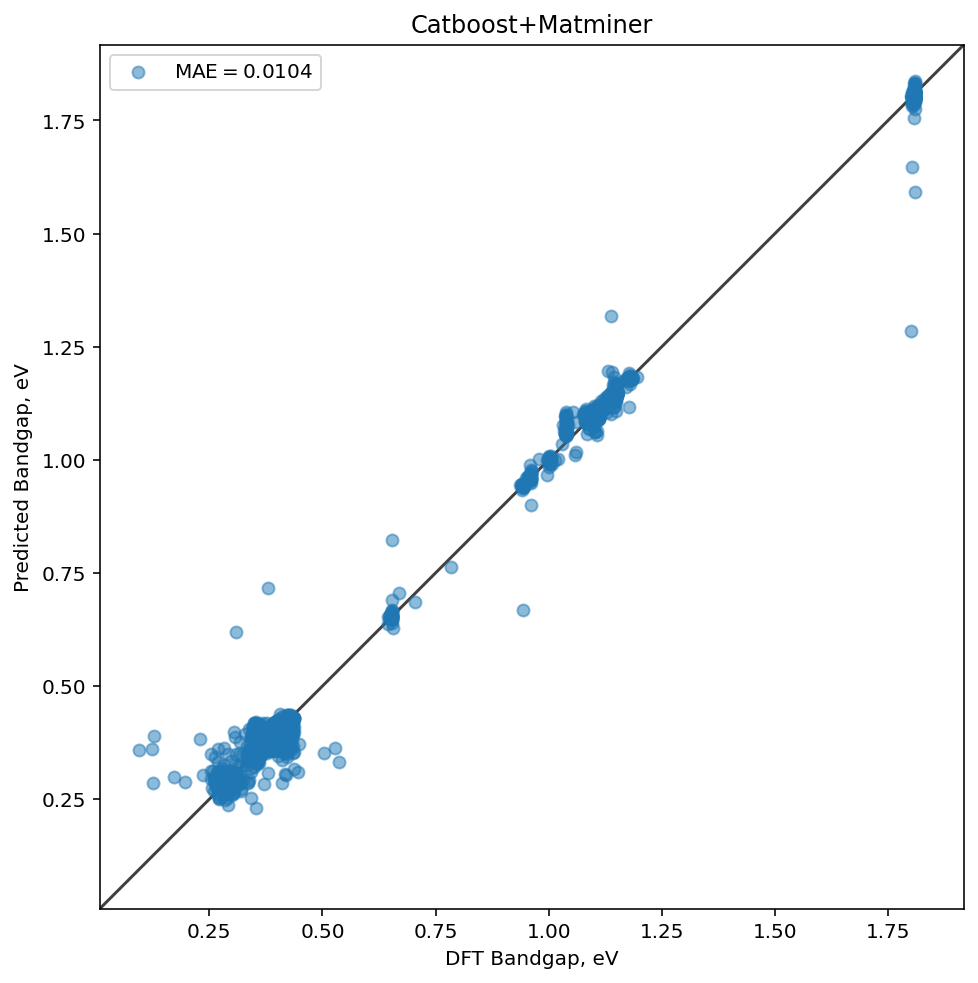

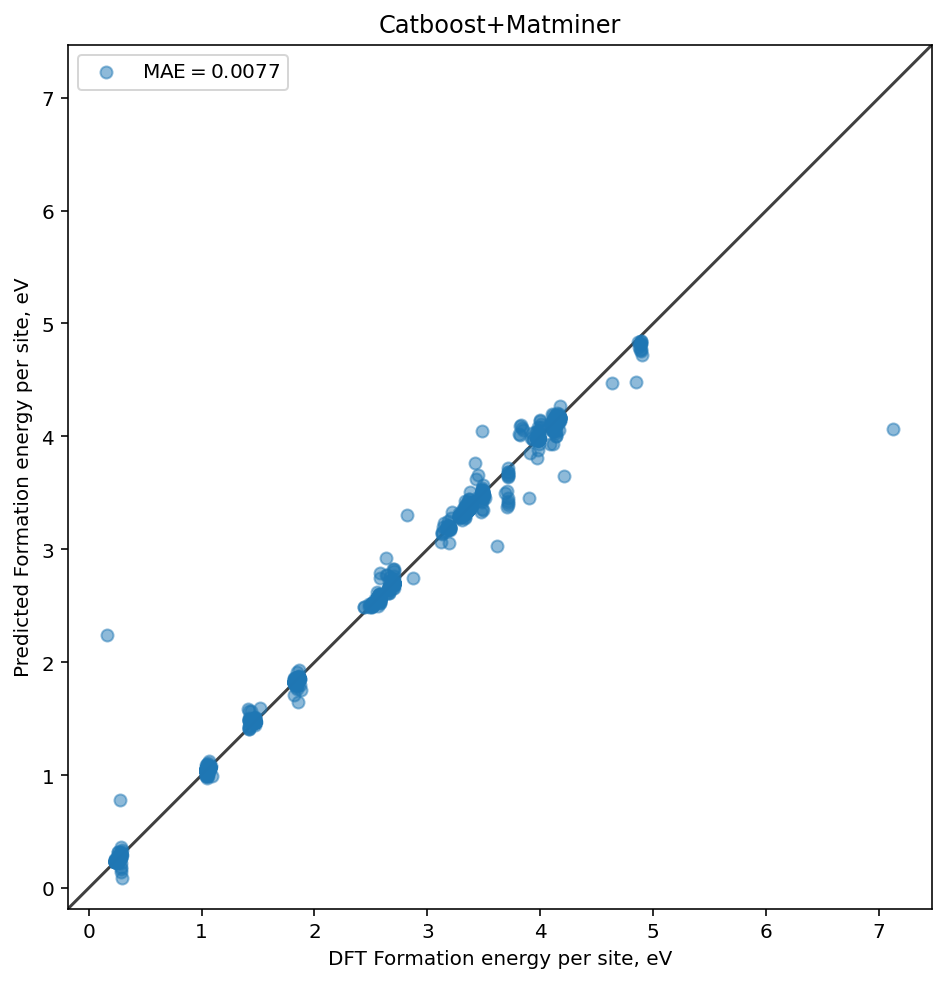

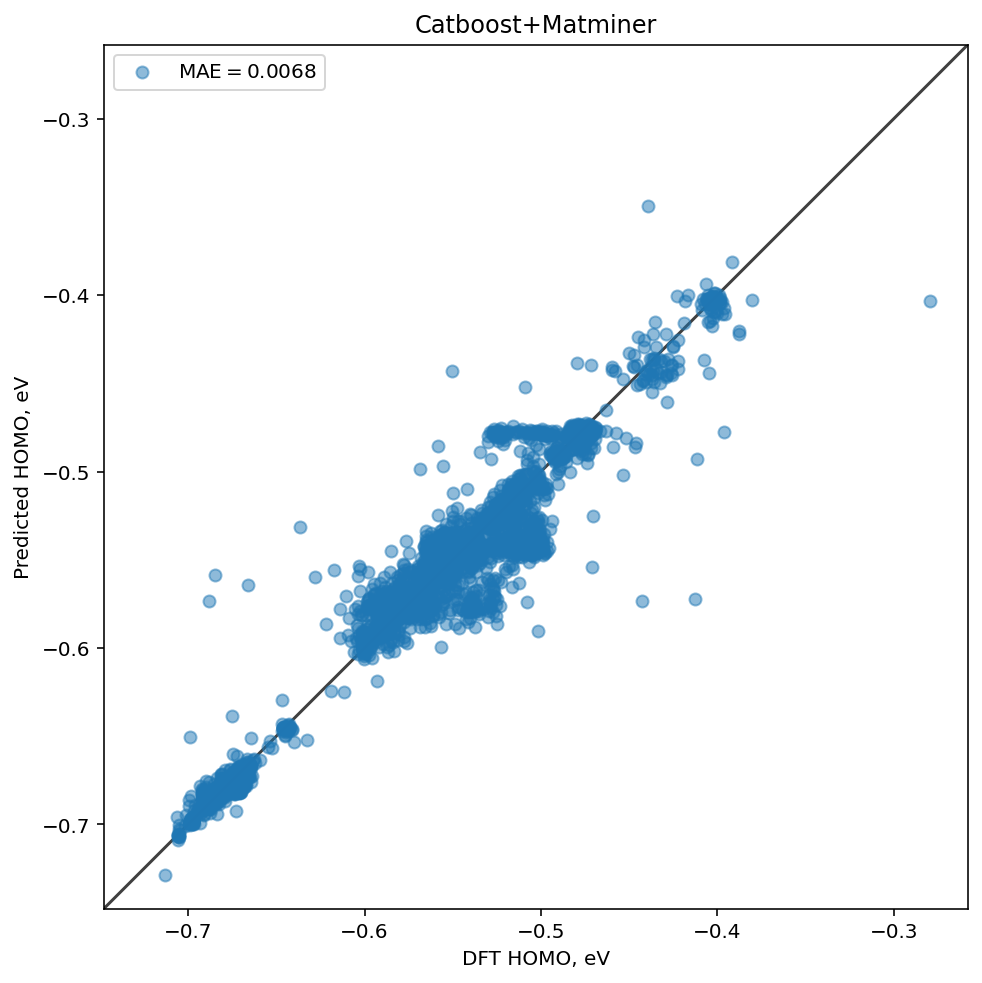

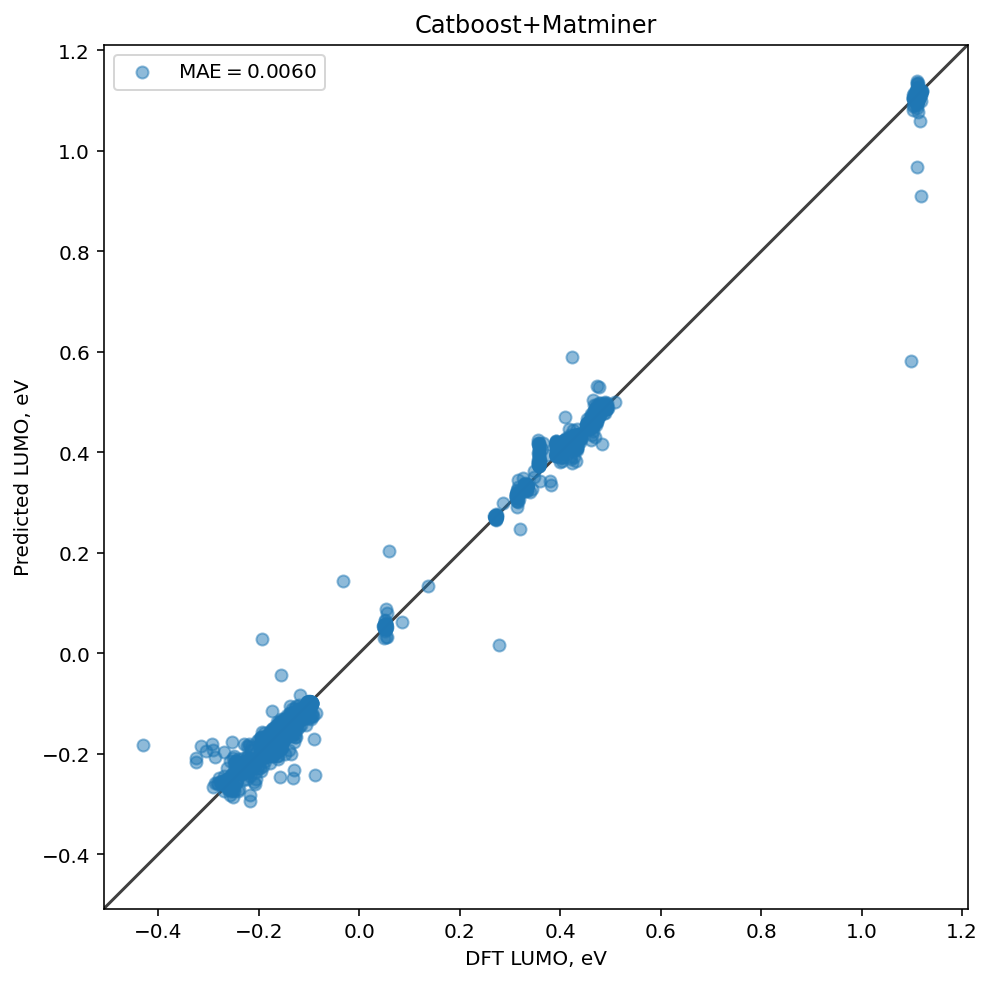

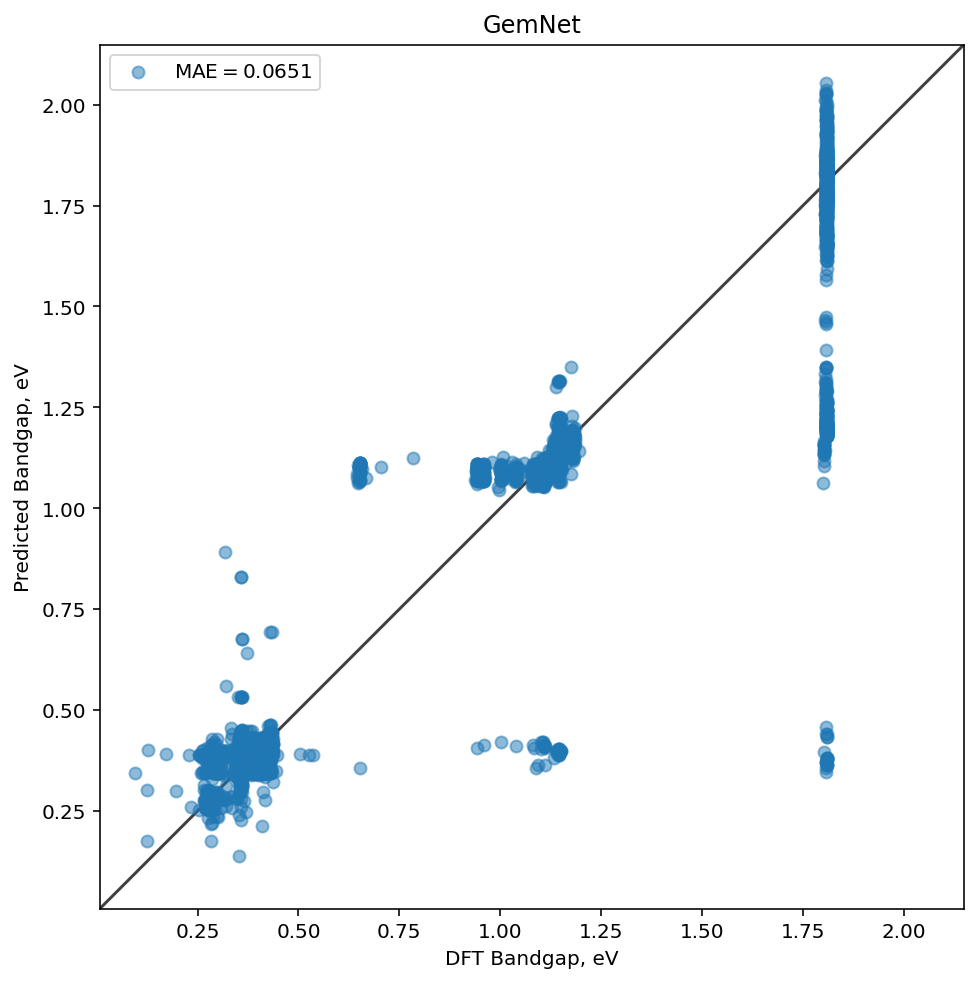

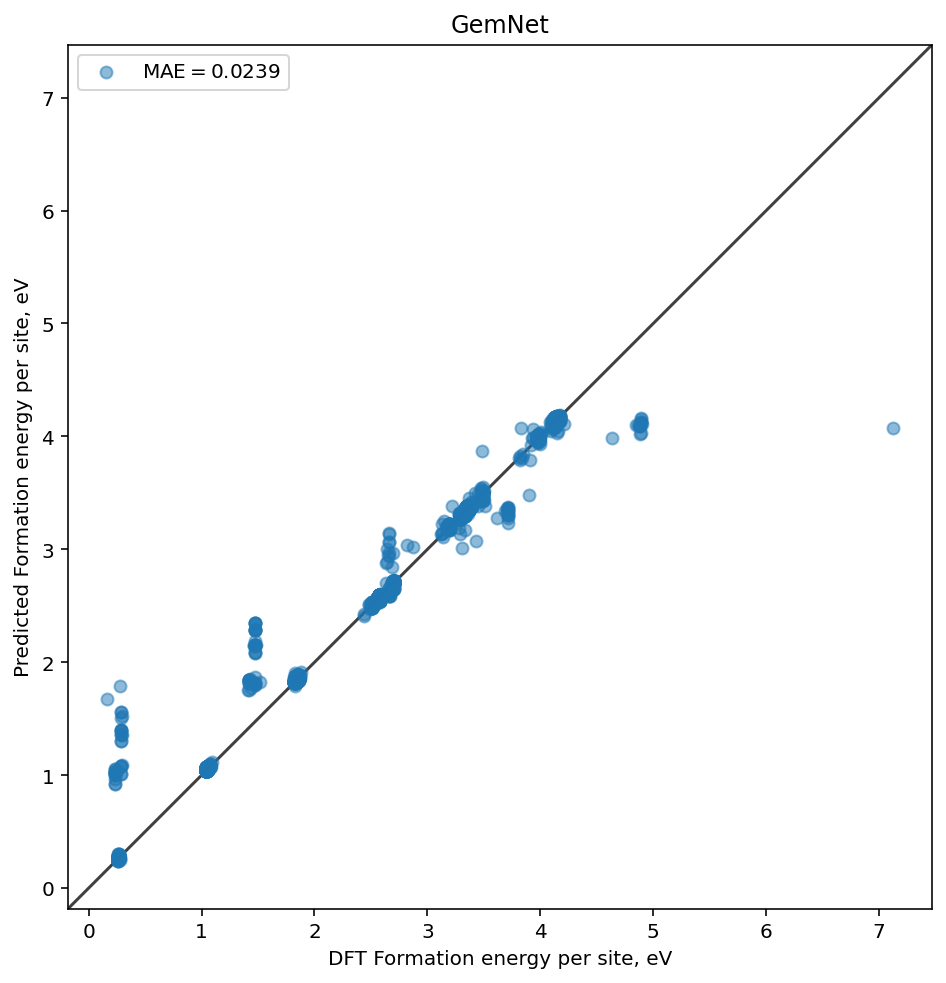

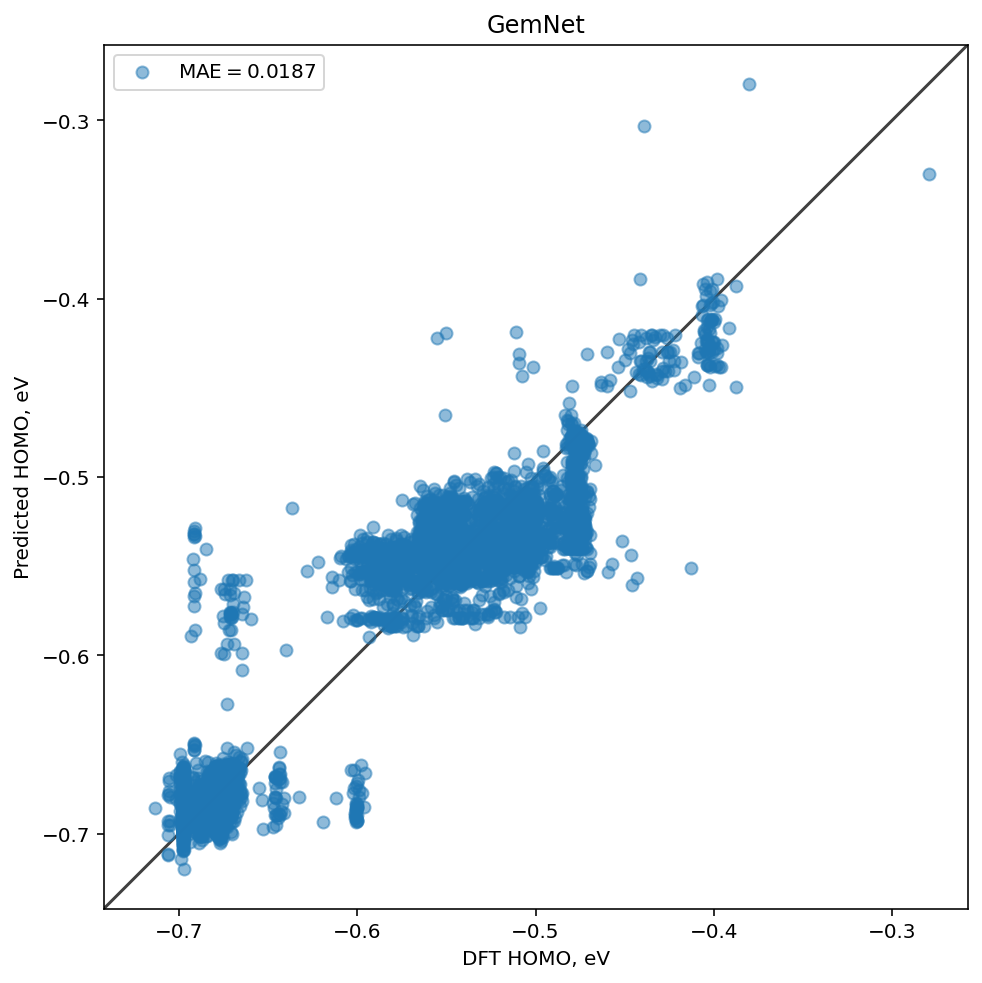

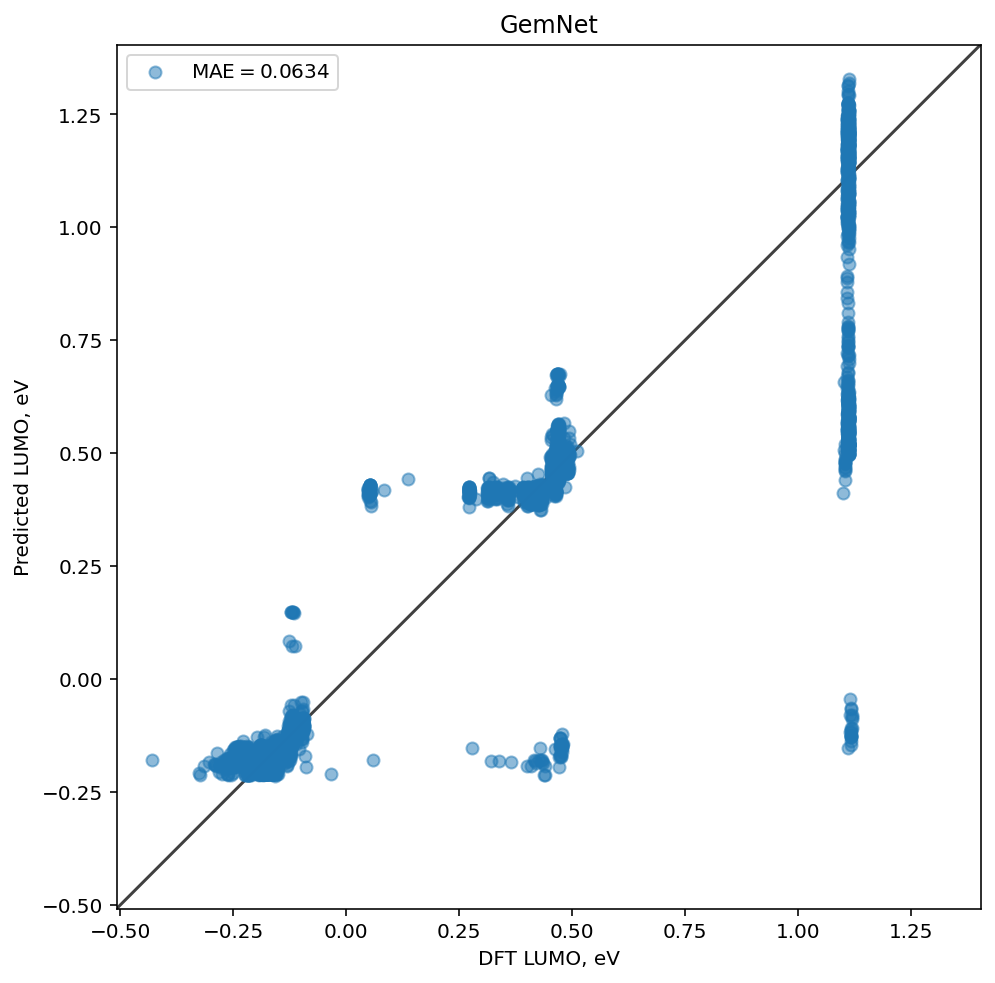

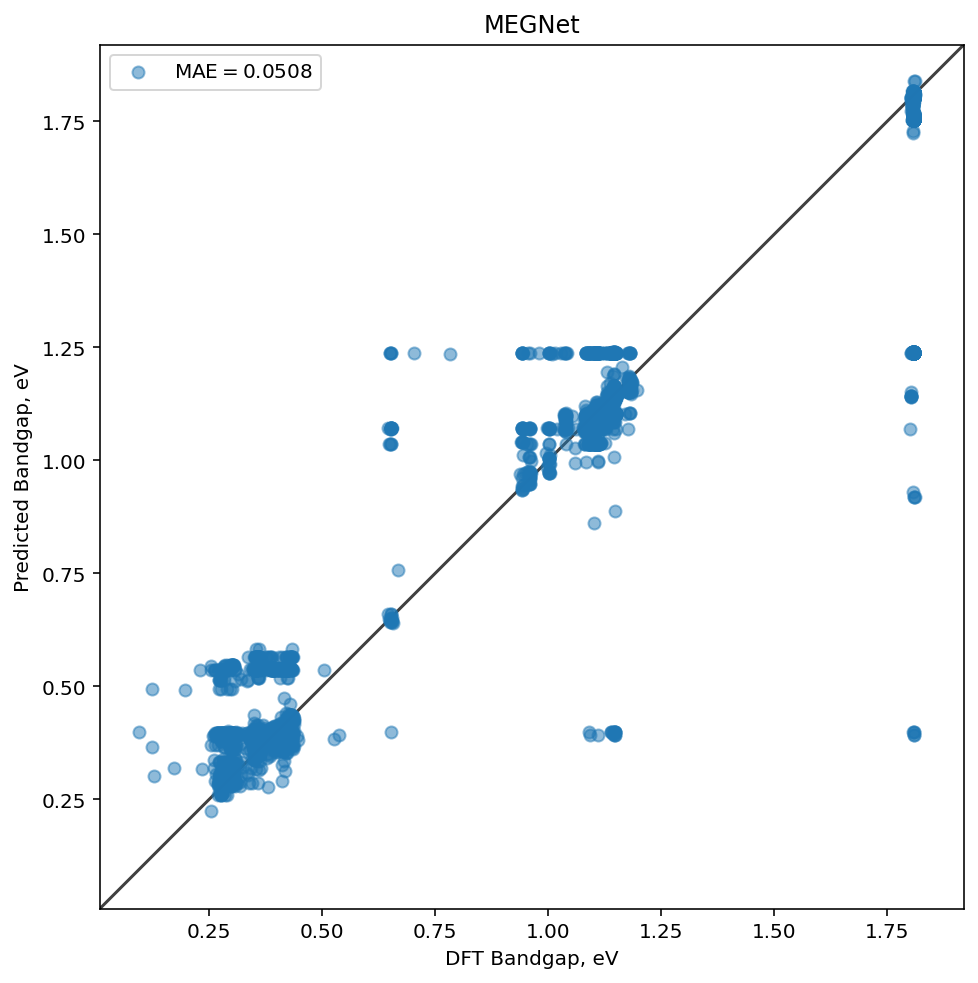

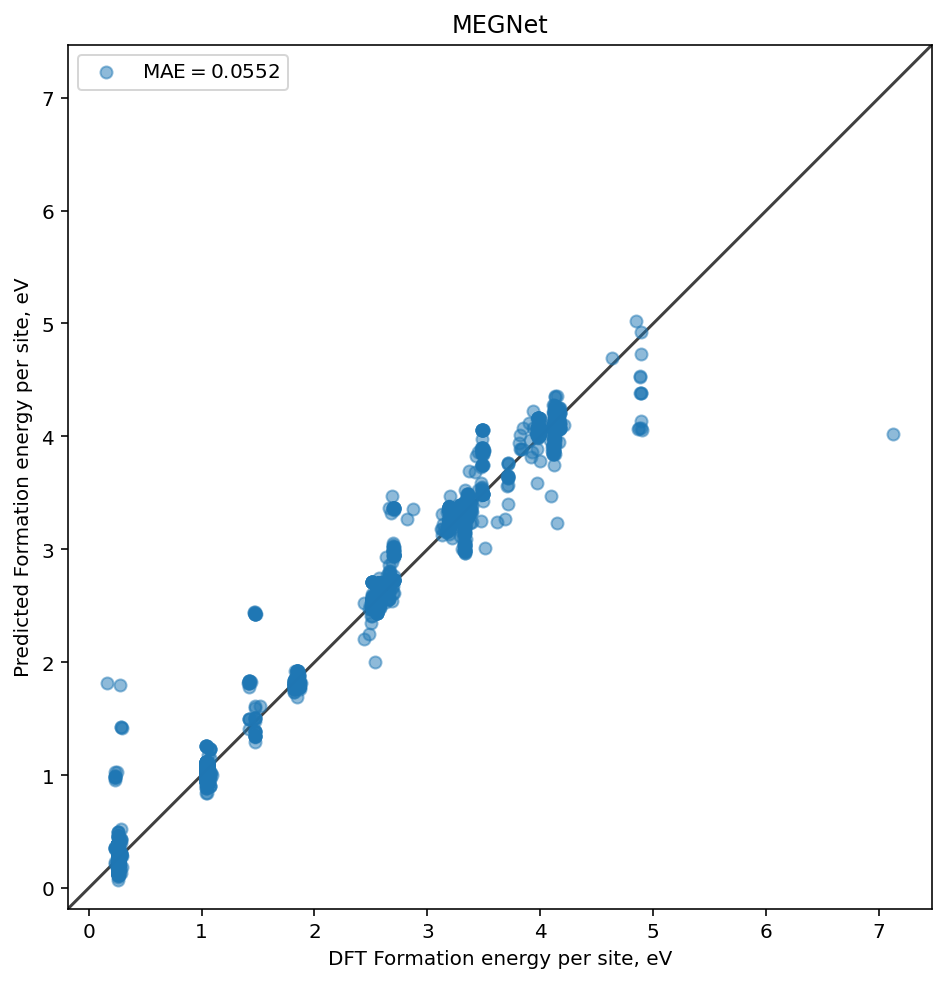

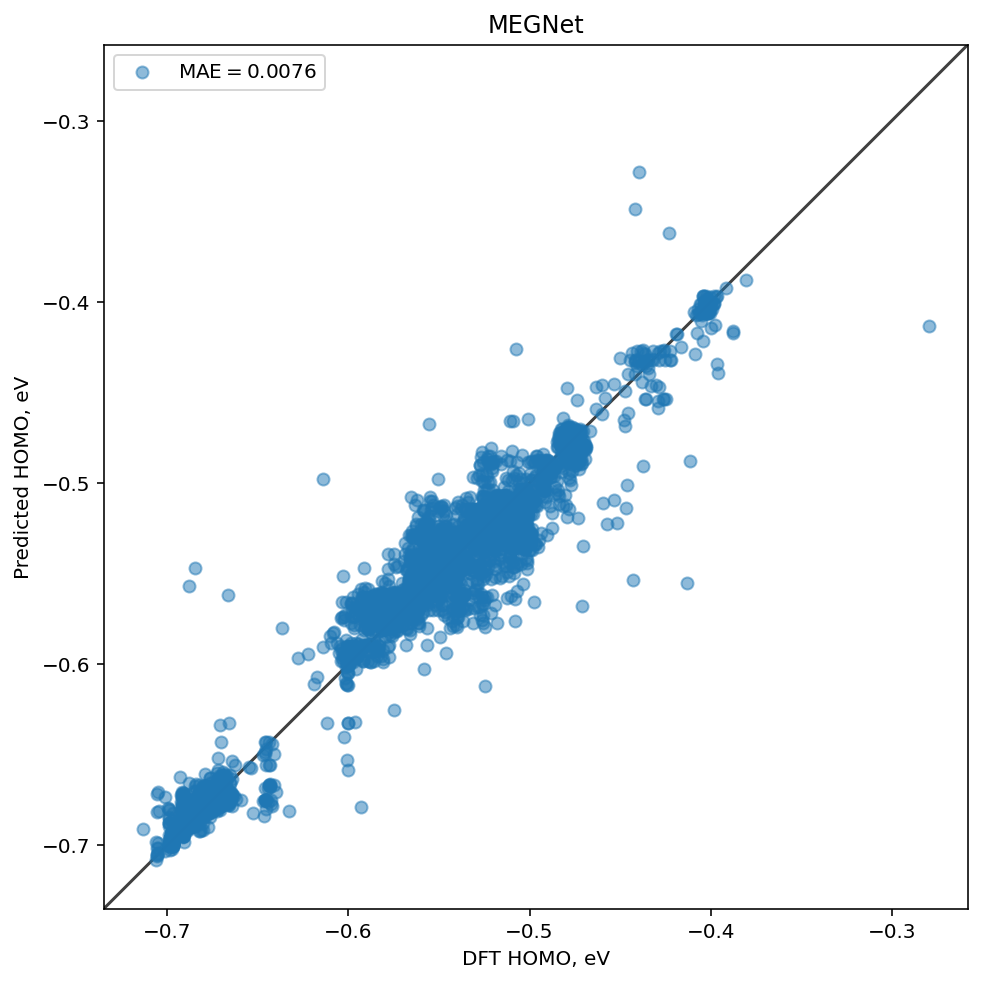

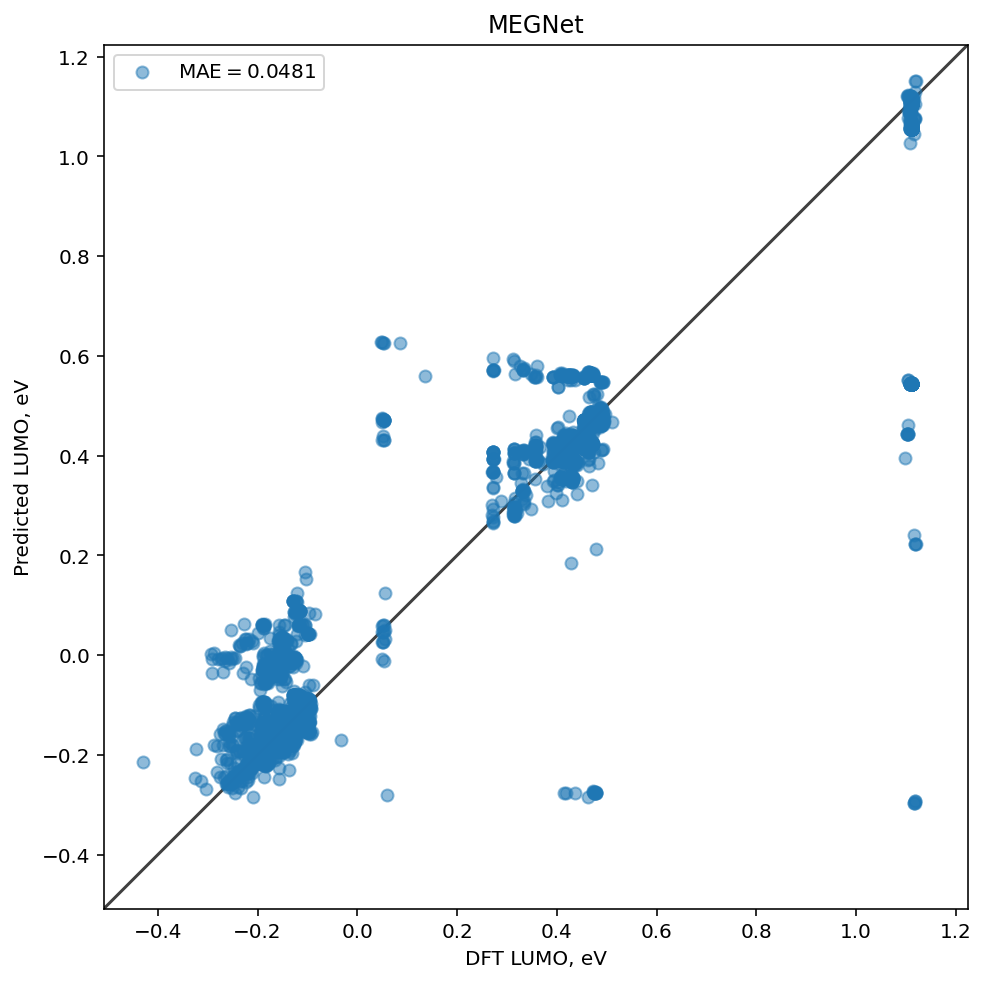

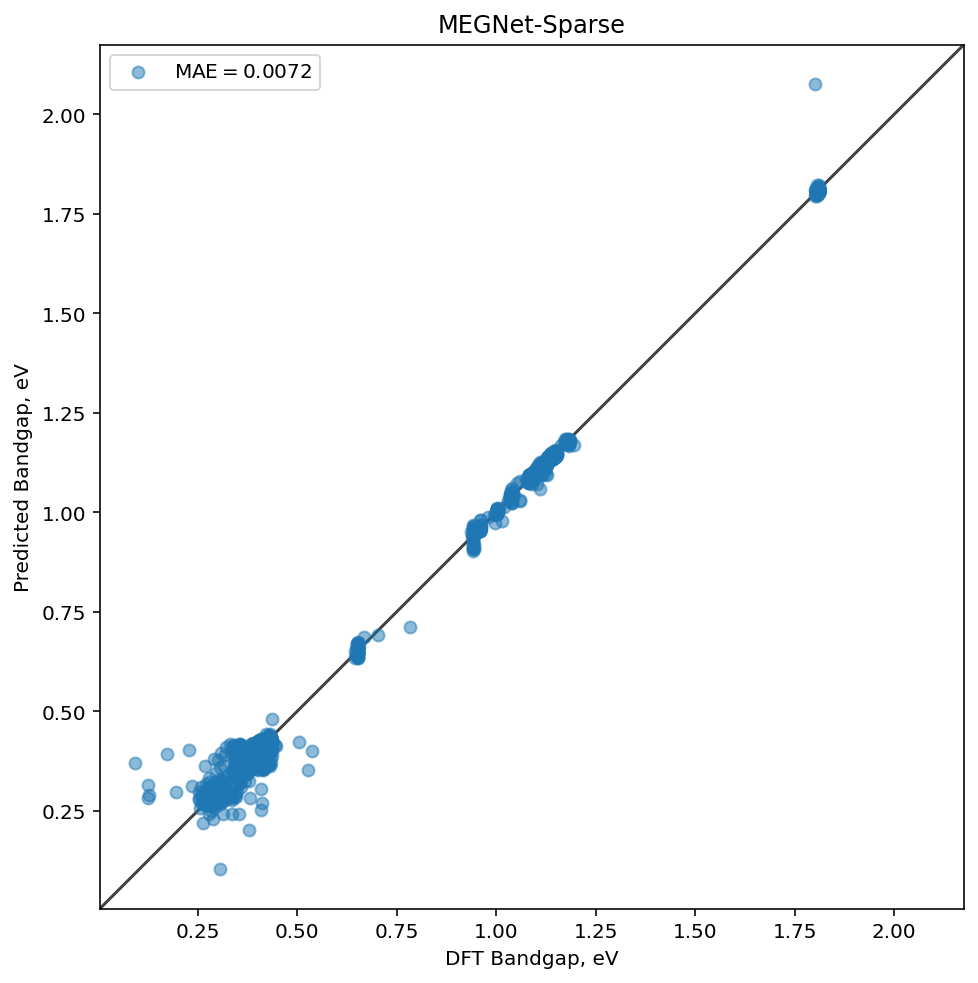

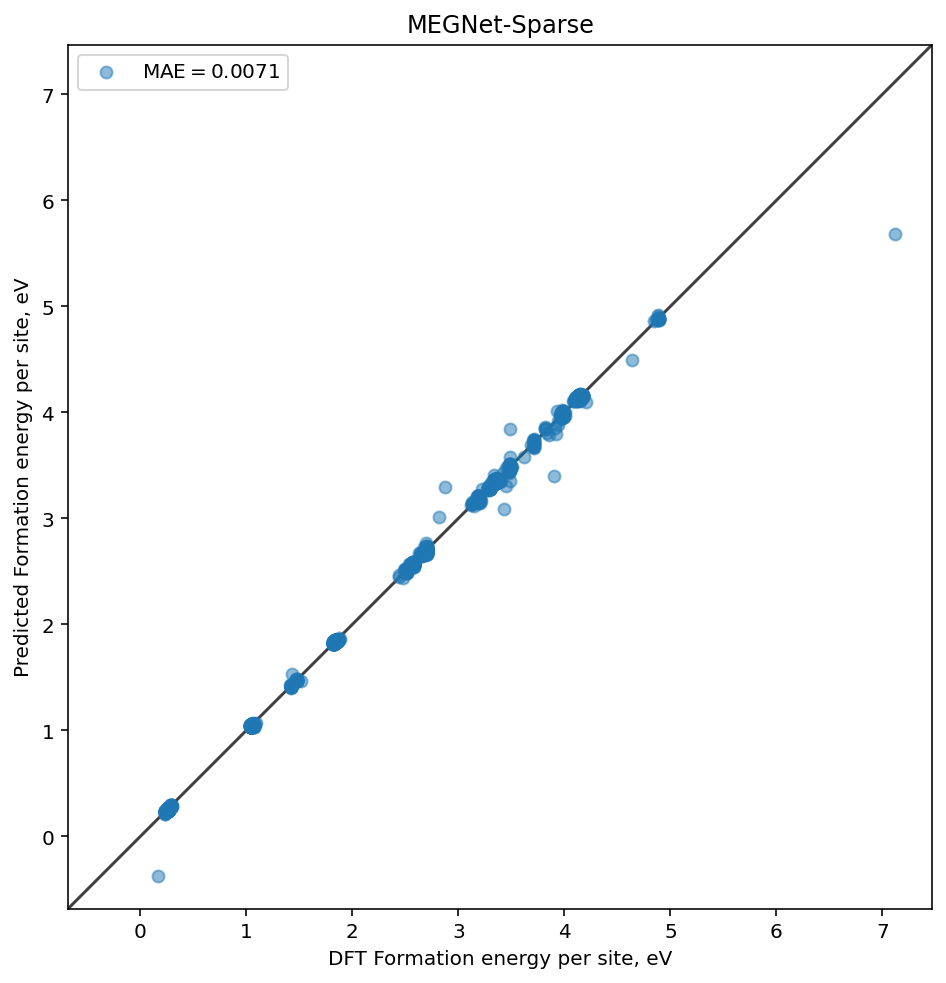

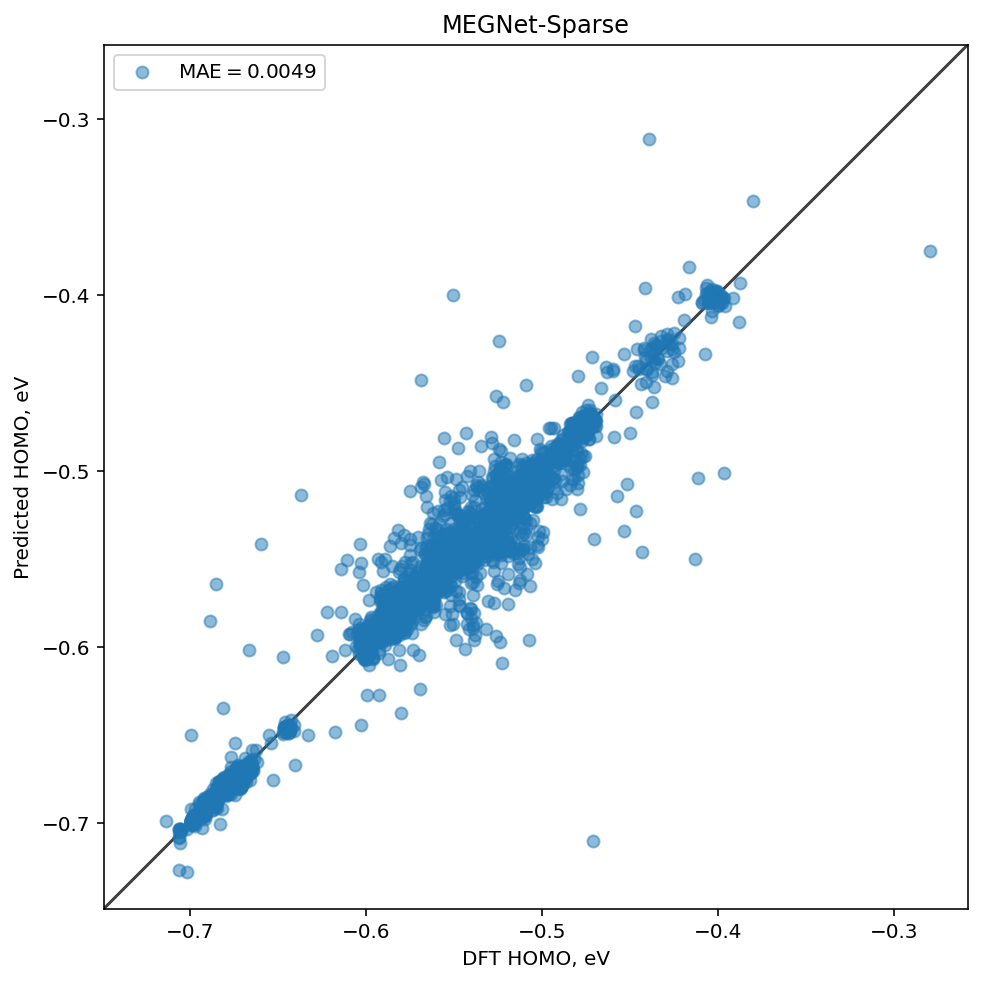

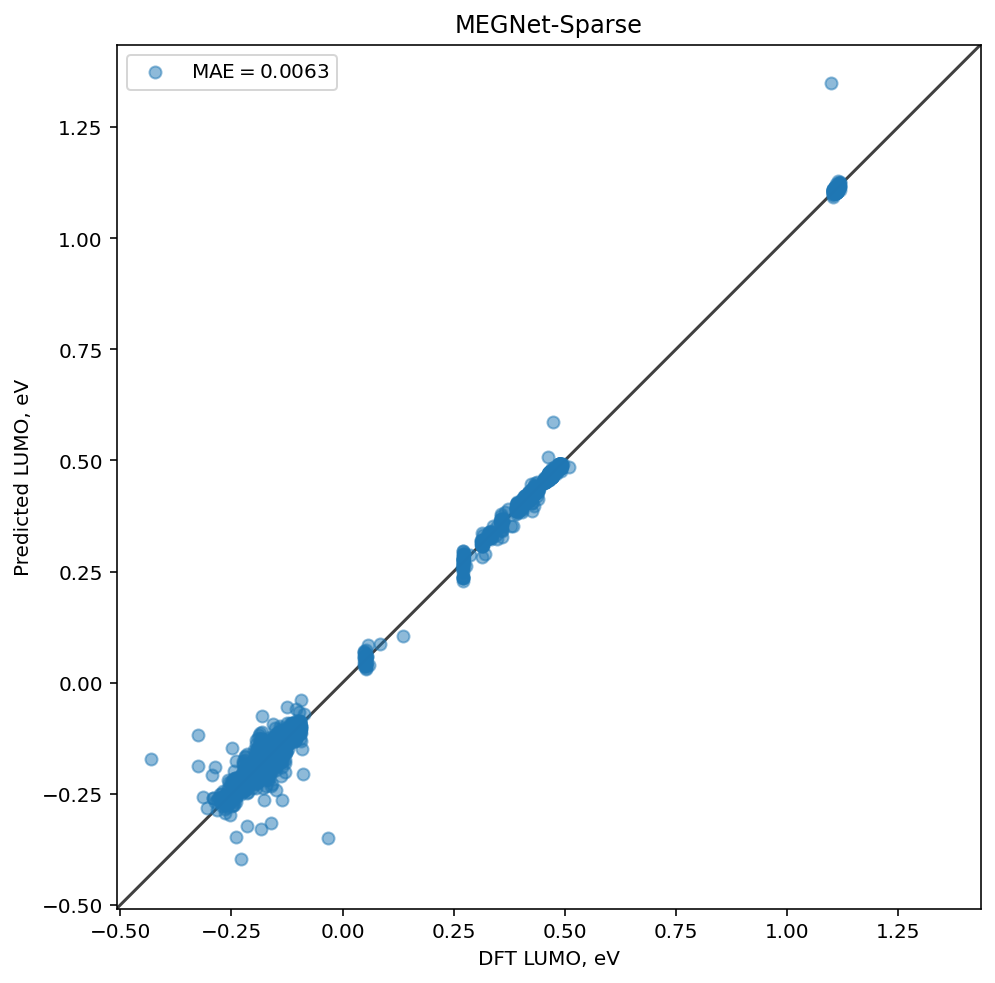

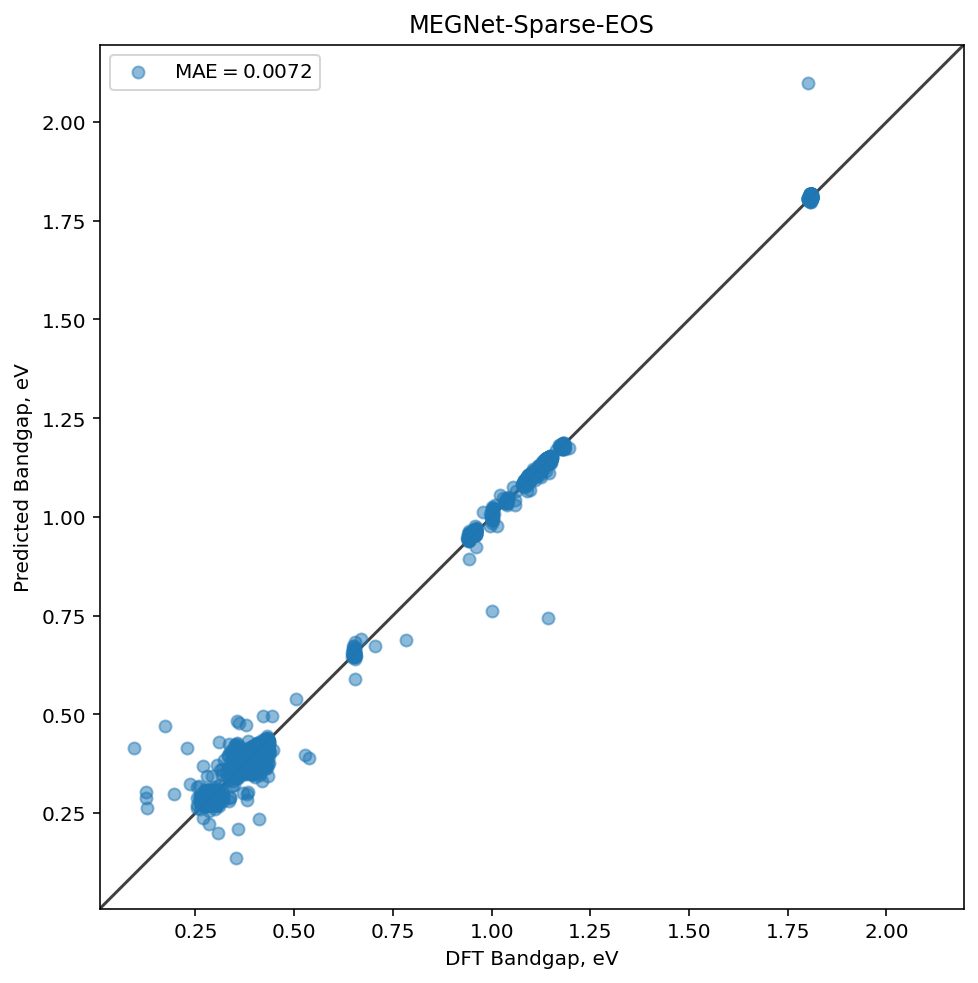

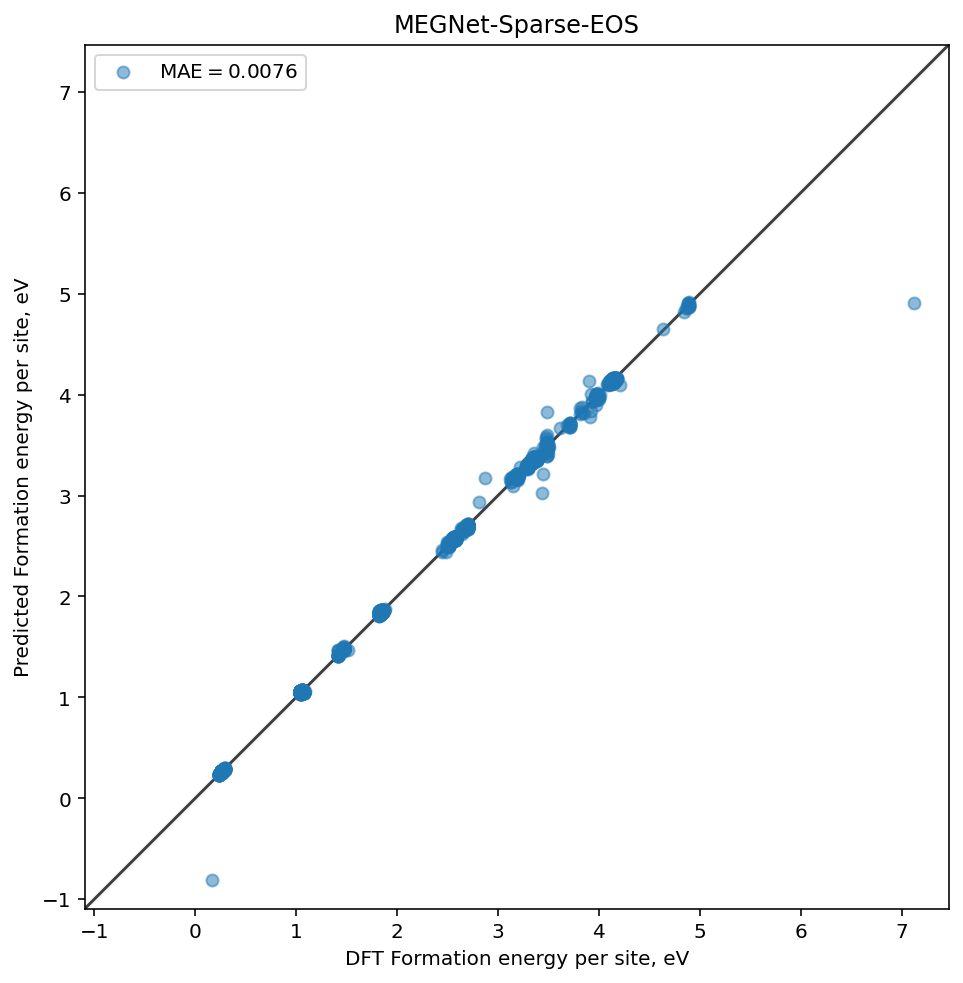

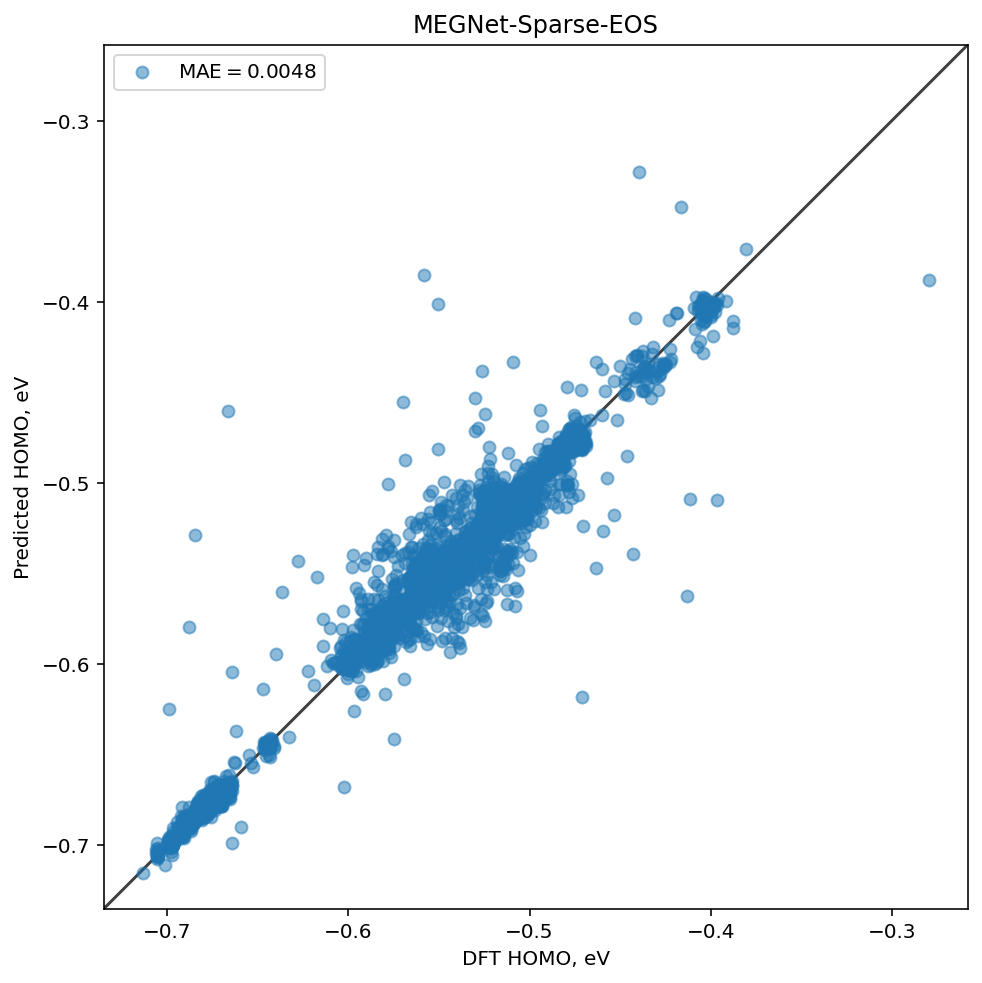

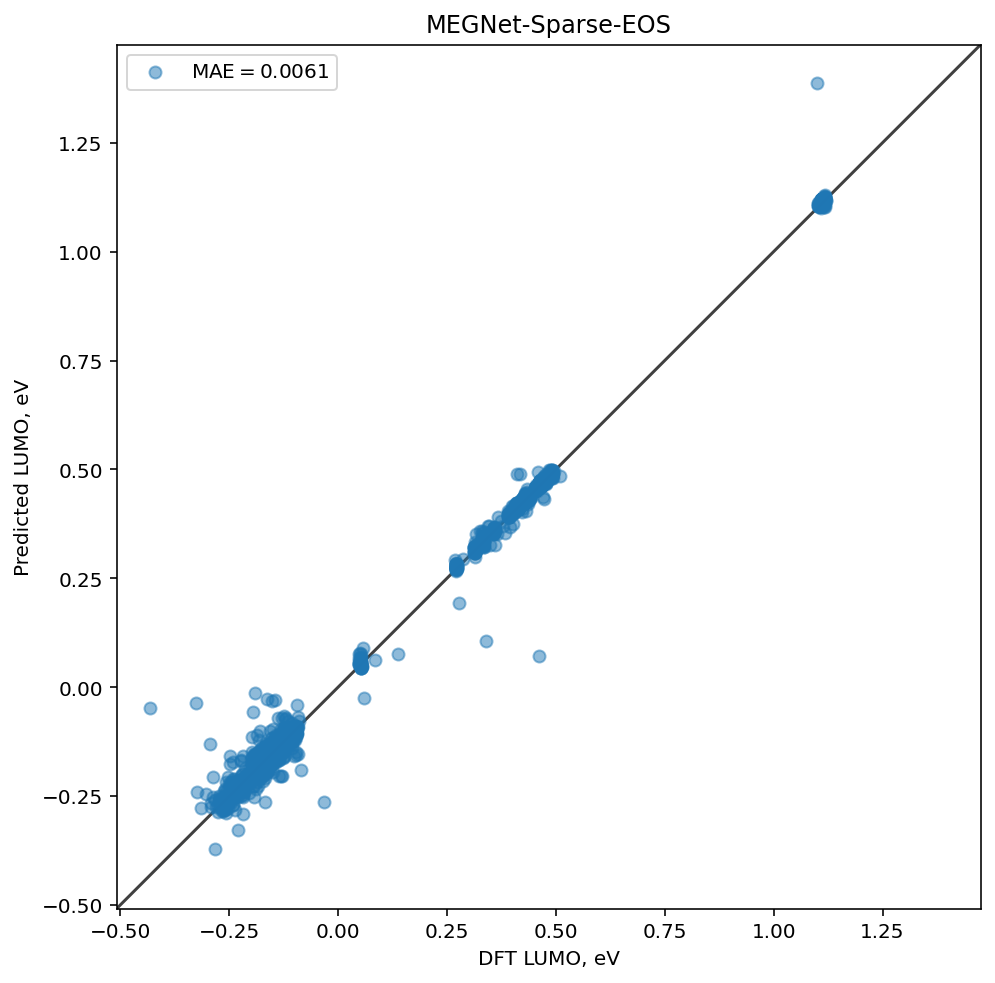

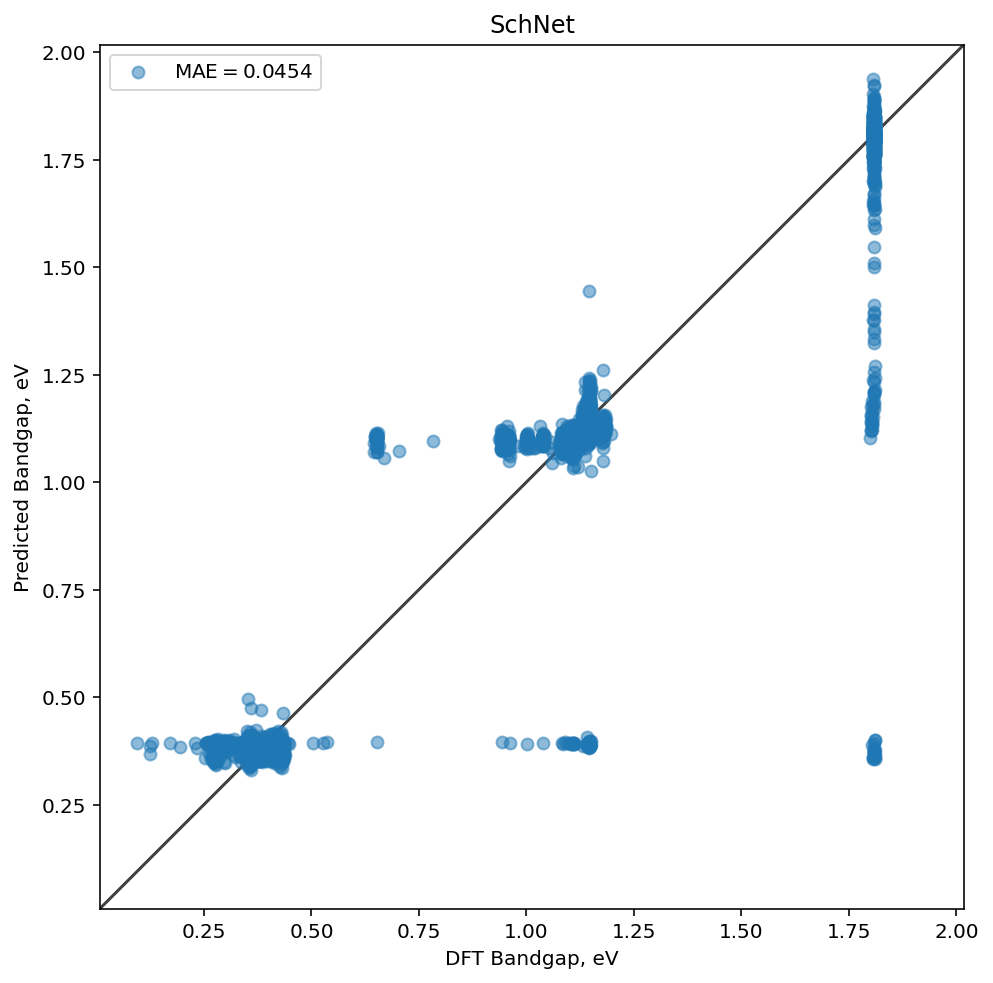

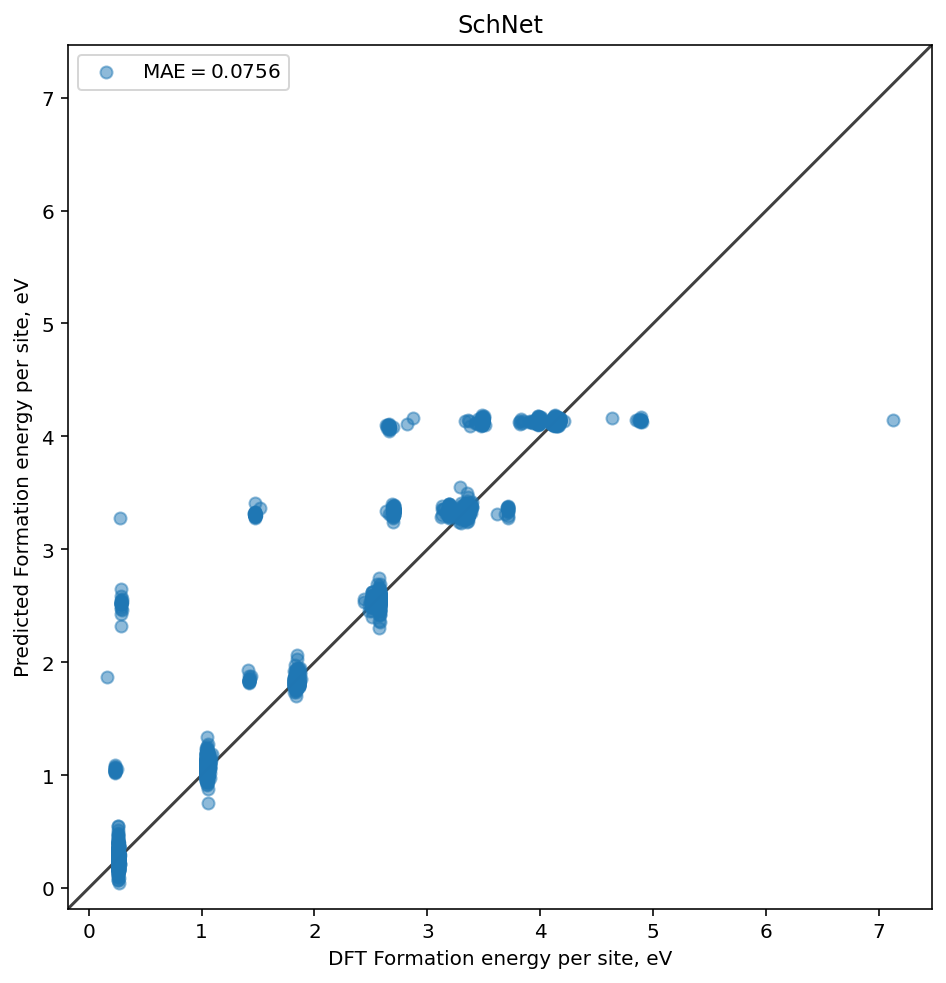

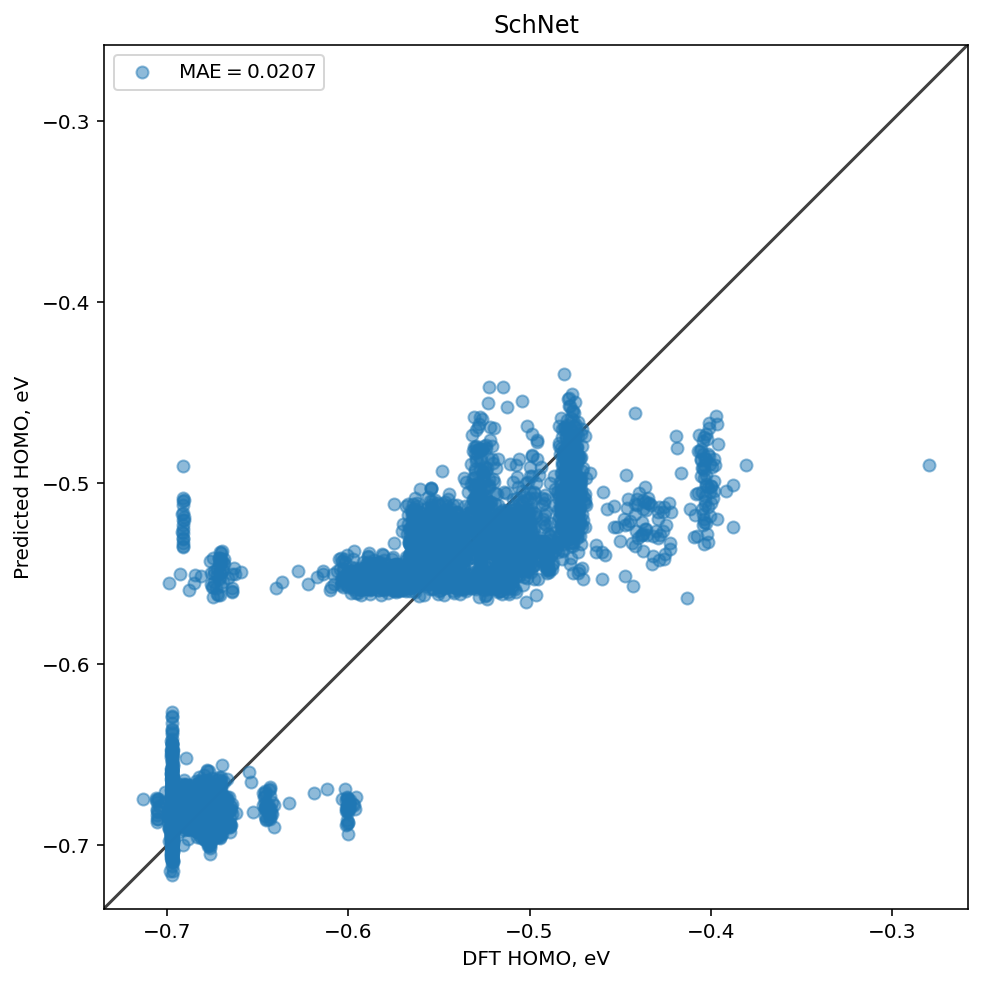

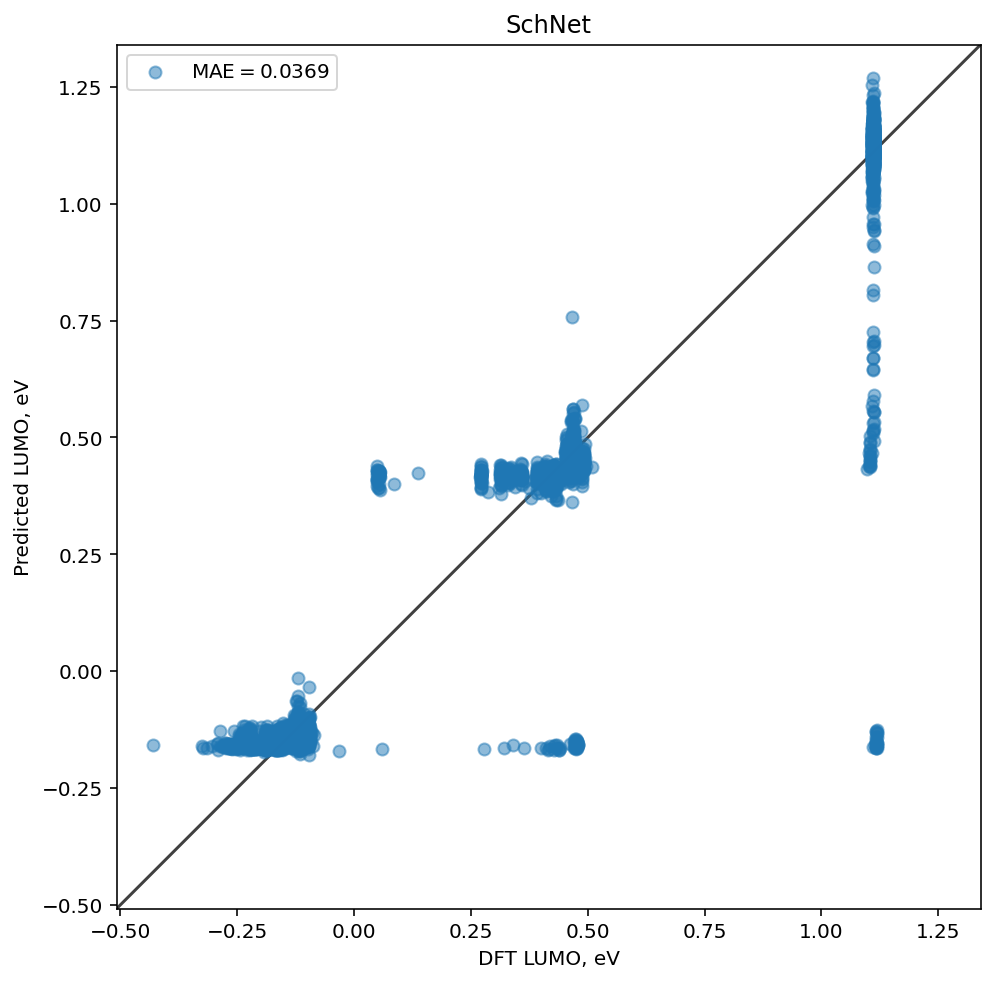

In [26]:
filenames = []
for (experiment, target_name), _ in predictions.groupby(level=(0, 1), axis=1):
    if experiment == 'DFT': continue
    filenames.append(
        plot(
            predictions=predictions[experiment][target_name],
            true_targets=predictions['DFT'][target_name],
            experiment_name=experiment,
            target_name=target_name_pretty_mapper.get(target_name)
    ))


In [27]:
def figure(between, caption):
    begin = r"\begin{figure}[htp!]"
    end = r"\end{figure}"
    body = [begin, '\n']
    for item in between:
        body.append(item)
        body.append('\n')
    if caption:
        body.append(f"\caption{{{caption}}}")
    body.extend(['\n' + end + '\n'])
    return ''.join(body)

def sub_figure(label, name, is_it_last=False):
    figure = r"\subcaptionbox{{ {label} \label{{ fig:{label} }} }} {{\includegraphics[width=0.5\textwidth]{{ {name} }} }}".format(label=label, name=name)
    spacer = "\hspace{0.1em}%"
    if is_it_last:
        return figure
    return figure + spacer


In [28]:
list_figures = []
# group by experiments
for i, (exper, files) in enumerate(groupby(filenames, lambda name: name.name.split('_')[0])):
    print(
        figure(
            [sub_figure(f"{filename.stem.split('_')[-1]}", filename, is_it_last=i%2) for i,  filename in enumerate(files)],
            caption=f'{exper} predictions.'
        )
    )


\begin{figure}[htp!]
\subcaptionbox{ Bandgap \label{ fig:Bandgap } } {\includegraphics[width=0.5\textwidth]{ plots/Catboost+Matminer_Bandgap.png } }\hspace{0.1em}%
\subcaptionbox{ Formation energy per site \label{ fig:Formation energy per site } } {\includegraphics[width=0.5\textwidth]{ plots/Catboost+Matminer_Formation energy per site.png } }
\subcaptionbox{ HOMO \label{ fig:HOMO } } {\includegraphics[width=0.5\textwidth]{ plots/Catboost+Matminer_HOMO.png } }\hspace{0.1em}%
\subcaptionbox{ LUMO \label{ fig:LUMO } } {\includegraphics[width=0.5\textwidth]{ plots/Catboost+Matminer_LUMO.png } }
\caption{Catboost+Matminer predictions.}
\end{figure}

\begin{figure}[htp!]
\subcaptionbox{ Bandgap \label{ fig:Bandgap } } {\includegraphics[width=0.5\textwidth]{ plots/GemNet_Bandgap.png } }\hspace{0.1em}%
\subcaptionbox{ Formation energy per site \label{ fig:Formation energy per site } } {\includegraphics[width=0.5\textwidth]{ plots/GemNet_Formation energy per site.png } }
\subcaptionbox{ HOMO \

# Model parameters

In [21]:
import yaml

In [352]:
for name in ['megnet', 'gemnet', 'schnet']:
    params = yaml.safe_load(open(f'../trials/{name}-full.yaml'))
    if name == 'megnet':
        print(pd.DataFrame.from_dict(params['model_params'], orient='index', columns=[f'{name} training parameters']).to_latex(label=name))
    else:
        print(pd.DataFrame.from_dict(params['model_params']['optim'], orient='index', columns=[f'{name} training parameters']).to_latex(label=name))

\begin{table}
\centering
\label{megnet}
\begin{tabular}{ll}
\toprule
{} & megnet training parameters \\
\midrule
add\_bond\_z\_coord   &                       True \\
atom\_features      &                          Z \\
learning\_rate      &                     0.0002 \\
epochs             &                        800 \\
nfeat\_edge\_per\_dim &                         10 \\
cutoff             &                          4 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\label{gemnet}
\begin{tabular}{ll}
\toprule
{} & gemnet training parameters \\
\midrule
max\_epochs         &                         50 \\
batch\_size         &                         32 \\
eval\_batch\_size    &                         32 \\
eval\_every         &                       5000 \\
num\_workers        &                          2 \\
lr\_initial         &                     0.0005 \\
optimizer          &                      AdamW \\
optimizer\_params   &          \{'amsgrad': True\} \\
sch

# Distance vs Energy plots

In [400]:
from pymatgen.core.structure import Structure
from pymatgen.util.coord import pbc_diff
from collections import defaultdict

In [274]:
structures = pd.read_pickle('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/data.pickle.gz')

In [652]:
def defect2_distance(structures):
    d1, d2 = structures
    # return d1.distance_from_point(d2.coords)
    return d1.distance(d2)


def defect3_distance(structures):
    d1, d2, d3 = structures
    # a = d1.distance_from_point(d2.coords)
    # b = d2.distance_from_point(d3.coords)
    # c = d1.distance_from_point(d3.coords)
    a = d1.distance(d2)
    b = d2.distance(d3)
    c = d1.distance(d3)

    d = np.sort(np.array([a, b, c]))#[::-1]
    v = np.array([1, 0.1, 0.01])

    return (d * v).sum()

# def defect3_distance(structures):
#     d1, d2, d3 = structures
#     f_exact = Fermat(alpha=1, path_method='FW')
#     f_exact.fit(structures.distance_matrix)
    

#     return np.tril(f_exact.get_distances()).sum()


In [618]:
def defects_counter(sites):
    defects = defaultdict(int)
    for s in sites:
        defects[f'z_{s.properties["was"]}'] += 1
    return defects

def num_defects(structures):
    structures['num_defects'] = structures.defect_representation.apply(lambda item: len(item))
    return structures

def vacancy_defects(structures):
    structures['V'] = structures.defect_representation.apply(lambda sites: list(filter(lambda site: site.species_string == 'X0+', sites))) \
                                                      .apply(lambda sites: defects_counter(sites))

    structures = pd.concat([structures, structures.V.apply(pd.Series)], axis=1)
    return structures


def defects_distance_v2(structures):
    v2 = structures.query('z_16==1 and z_42==1 and num_defects==2')
    return pd.Series(v2['defect_representation'].apply(defect2_distance), name='distance')

def defects_distance_v3(structures):
    v3 = structures.query('z_16==2 and z_42==1 and num_defects==3')
    return pd.Series(v3['defect_representation'].apply(defect3_distance), name='distance')


In [634]:
v2 = defects_distance_v2(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

In [653]:
v3 = defects_distance_v3(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

In [650]:
import matplotlib.cm as cm

In [659]:
def plot(d, e, legend, ax, color, alpha=0.5, **kwargs):
    args = np.argsort(d)
    ax.plot(d[args], e[args] , 'o', color=color, label=legend, mfc='white', **kwargs)

    ax.plot(d[args], e[args], alpha=alpha, zorder=-1)
    ax.legend()
    return ax

Text(0.5, 1.0, 'V2')

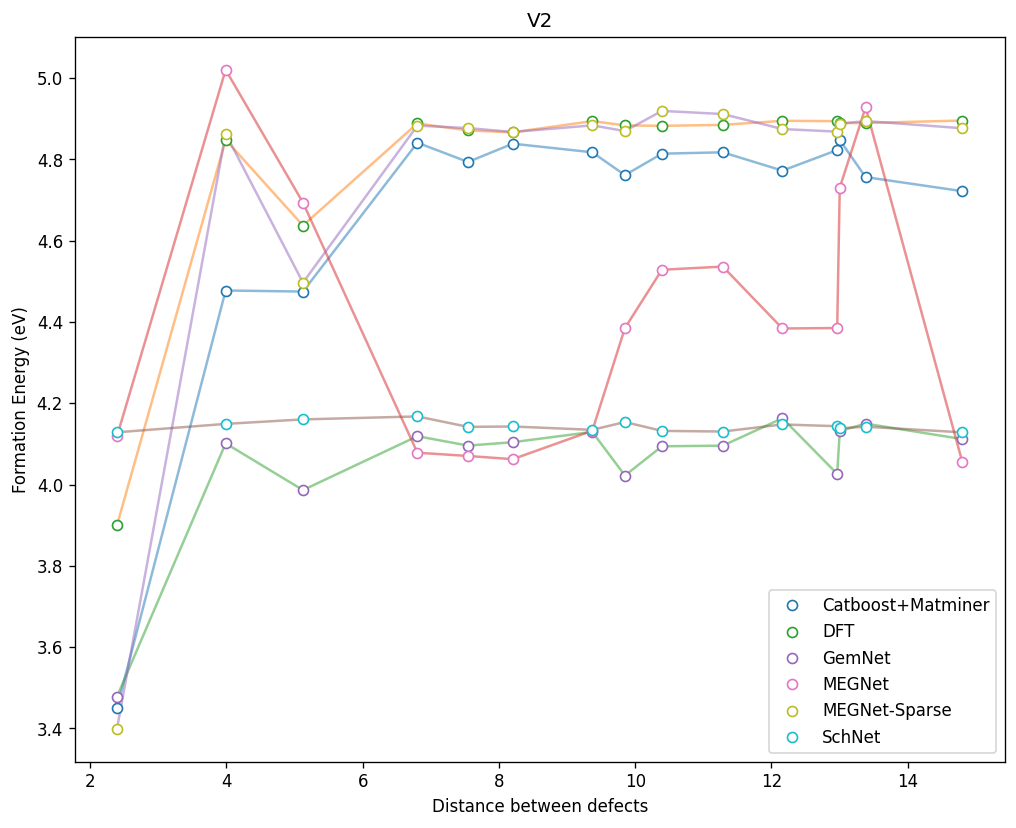

In [657]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v2.index].droplevel(1).assign(v2=v2)

    plot(
        pred.v2,
        pred.formation_energy_per_site,
        legend=legend,
        color=next(colors),
        ax=ax,

        
    )

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Distance between defects')
ax.set_title('V2')

In [626]:
predictions

Catboost+Matminer                            \
                                        band_gap formation_energy_per_site   
_id                      folds                                               
6141cf0efbfd4bd9ab2c2f7e 2              1.117471                  2.769009   
6141cf0f51c1cbd9654b8870 2              1.057708                  2.659575   
6141cf0fe689ecc4c43cdd4b 3              1.647190                  0.784382   
6141cf10b842c2e72e2f2d44 5              1.804401                  0.184275   
6141cf1051c1cbd9654b8872 4              1.096639                  2.669430   
...                                          ...                       ...   
6148f3f63ac25c70a5c6cdff 5              0.356436                  4.146777   
6149087231cf3ef3d4a9f848 6              0.260021                  3.296777   
6149c48031cf3ef3d4a9f84a 7              0.376480                  3.412673   
6149f3853ac25c70a5c6ce01 7              0.363715                  4.090032   
615083823ac25c70a5c6ce03 1              0.374448                  3.986911   

                                                        DFT             \
                                    homo      lumo band_gap     energy   
_id                      folds                                           
6141cf0efbfd4bd9ab2c2f7e 2     -0.638735  0.478736   1.1452 -1391.3404   
6141cf0f51c1cbd9654b8870 2     -0.677077  0.380630   1.0843 -1384.5528   
6141cf0fe689ecc4c43cdd4b 3     -0.678564  0.968627   1.8033 -1397.1961   
6141cf10b842c2e72e2f2d44 5     -0.684090  1.120311   1.8095 -1396.2576   
6141cf1051c1cbd9654b8872 4     -0.670878  0.425762   1.1102 -1384.5327   
...                                  ...       ...      ...        ...   
6148f3f63ac25c70a5c6cdff 5     -0.541923 -0.185487   0.3526 -1366.4702   
6149087231cf3ef3d4a9f848 6     -0.432594 -0.172573   0.3002 -1372.5659   
6149c48031cf3ef3d4a9f84a 7     -0.507742 -0.131262   0.3594 -1372.2370   
6149f3853ac25c70a5c6ce01 7     -0.573291 -0.209576   0.5270 -1367.4786   
615083823ac25c70a5c6ce03 1     -0.578072 -0.203624   0.4295 -1367.1699   

                                                                             \
                               energy_per_atom fermi_level formation_energy   
_id                      folds                                                
6141cf0efbfd4bd9ab2c2f7e 2           -7.284505   -0.199707           2.6457   
6141cf0f51c1cbd9654b8870 2           -7.287120   -0.220627           5.3063   
6141cf0fe689ecc4c43cdd4b 3           -7.277063   -0.183537           0.2790   
6141cf10b842c2e72e2f2d44 5           -7.272175   -0.179802           0.5795   
6141cf1051c1cbd9654b8872 4           -7.287014   -0.213190           5.3264   
...                                        ...         ...              ...   
6148f3f63ac25c70a5c6cdff 5           -7.230001   -0.359015          12.4557   
6149087231cf3ef3d4a9f848 6           -7.224031   -0.300181           9.8490   
6149c48031cf3ef3d4a9f84a 7           -7.222300   -0.324836          10.1779   
6149f3853ac25c70a5c6ce01 7           -7.235337   -0.424306          11.4473   
615083823ac25c70a5c6ce03 1           -7.233703   -0.398333          11.7560   

                                                          ...    MEGNet  \
                               formation_energy_per_site  ...      homo   
_id                      folds                            ...             
6141cf0efbfd4bd9ab2c2f7e 2                      2.645700  ... -0.667460   
6141cf0f51c1cbd9654b8870 2                      2.653150  ... -0.670360   
6141cf0fe689ecc4c43cdd4b 3                      0.279000  ... -0.682917   
6141cf10b842c2e72e2f2d44 5                      0.289750  ... -0.694724   
6141cf1051c1cbd9654b8872 4                      2.663200  ... -0.666106   
...                                                  ...  ...       ...   
6148f3f63ac25c70a5c6cdff 5                      4.151900  ... -0.537053   
6149087231cf3ef3d4a9f848 6                  

Text(0.5, 1.0, 'V3')

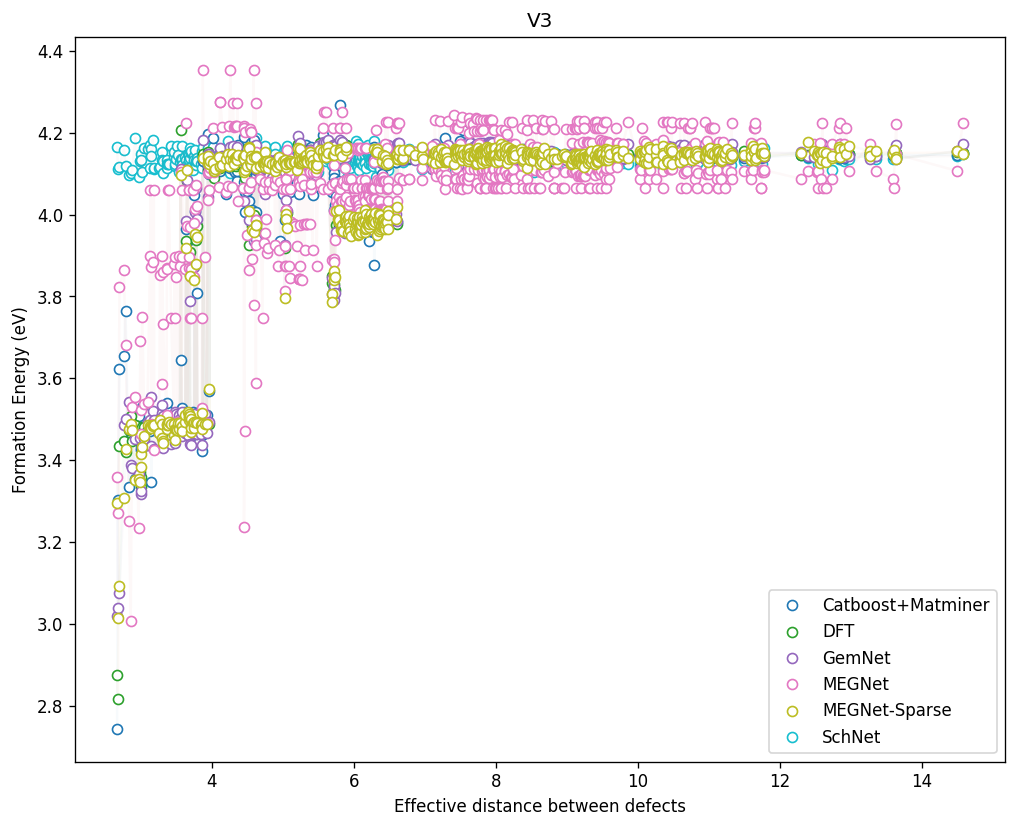

In [660]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v3.index].droplevel(1).assign(v3=v3)
    # if 'DFT' in legend:
    plot(
        pred.v3,
        pred.formation_energy_per_site,
        legend=legend,
        ax=ax,
        color=next(colors),
        alpha=0.03,
        zorder=-1 if 'SchNet' in legend else 1
    )

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Effective distance between defects')
ax.set_title('V3')